In [1]:
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import numpy as np
import os
import nrrd
import pytorch_lightning as pl
from monai.data import Dataset, DataLoader
from monai.transforms import Compose, Lambda, RandSpatialCrop, RandRotate90, ToTensor
from monai.networks.nets import UNet
#from monai.losses import DiceLoss
import tensorflow as tf
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [22]:
import shutil

def clear_tensorboard_logs(log_dir):
    # Ensure the directory exists
    if os.path.exists(log_dir):
        # Delete the directory and its contents
        shutil.rmtree(log_dir)
        print("TensorBoard logs cleared successfully.")
    else:
        print("TensorBoard logs directory not found.")

def clear_logs(logs_dir):
    """Clear all logs in the specified directory."""
    try:
        shutil.rmtree(logs_dir)
        print(f"All logs in {logs_dir} have been cleared.")
    except FileNotFoundError:
        print(f"No logs found in {logs_dir}.")
def clear_runs_and_logs(logs_dir):
    """Clear all runs and logs in the specified directory."""
    try:
        shutil.rmtree(logs_dir)
        print(f"All runs and logs in {logs_dir} have been cleared.")
    except FileNotFoundError:
        print(f"No runs or logs found in {logs_dir}.")

# Specify the directory containing all runs and logs
runs_and_logs_dir = "./runs_and_logs/"
log_dir = "./logs/"
tensorboard_logs_dir = "./tensorboard_logs/"
lightning_logs_dir = "./lightning_logs/"
# Clear TensorBoard logs
clear_tensorboard_logs(log_dir)
clear_logs(lightning_logs_dir)
clear_runs_and_logs(runs_and_logs_dir)

TensorBoard logs directory not found.
No logs found in ./lightning_logs/.
No runs or logs found in ./runs_and_logs/.


In [29]:
class AutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.unet = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=3,  # Update to 3 output channels
            channels=(16, 32, 64, 128, 1),  # Correct parentheses
            strides=(2, 2, 2, 2),
            num_res_units=2,
        )
        # Define class weights
        class_weights = torch.tensor([0.2, 0.4, 0.4])
        self.loss_function = CrossEntropyLoss(weight=class_weights)

    def forward(self, x):
        return self.unet(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.unet(x)
        loss = self.loss_function(x_hat, y.squeeze(1).long())  # Ensure labels are in the range [0, 2]
        self.log('train_loss', loss)

        # Reconstruct and display a single slice from the first training image every other epoch
        if self.current_epoch % 10 == 0 and batch_idx == 0:
            original_slice = x[0, 0, :, :, 128].detach().cpu().numpy()  # Select a single slice from the 3D volume
            reconstruction_slice = np.argmax(x_hat[0,:,:,:,128], axis=0) # Select a single slice from the 3D reconstruction

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(original_slice, cmap='gray')
            plt.title('Original Train Slice')
            plt.subplot(1, 2, 2)
            plt.imshow(reconstruction_slice, cmap='gray')
            plt.title('Reconstructed Train Slice')
            plt.show()

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.unet(x)
        loss = self.loss_function(x_hat, y.squeeze(1).long())  # Ensure labels are in the range [0, 2]
        self.log('val_loss', loss, prog_bar=True)

        # Reconstruct and display a single slice from the first validation image every other epoch
        if self.current_epoch % 10 == 0 and batch_idx == 0:
            original_slice = x[0, 0, :, :, 128].detach().cpu().numpy()  # Select a single slice from the 3D volume
            #reconstruction_slice = self.unet(x[0].unsqueeze(0))[0, 0, :, :, 128].detach().cpu().numpy()  # Select a single slice from the 3D reconstruction
            reconstruction_slice = np.argmax(x_hat[0,:,:,:,128], axis=0)
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(original_slice, cmap='gray')
            plt.title('Original Val Slice')
            plt.subplot(1, 2, 2)
            plt.imshow(reconstruction_slice, cmap='gray')
            plt.title('Reconstructed Val Slice')
            plt.show()

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


# Define dataset and data loaders for both training and validation sets
train_data_dir = "./images/TrainFullLabels70"
val_data_dir = "./images/ValFullLabels30"

transform = Compose([
    Lambda(func=lambda x: np.expand_dims(x, 0) if x.ndim == 3 else x),
    RandSpatialCrop((256, 256, 256), random_size=False),
    RandRotate90(prob=0.5),
    ToTensor(dtype=torch.float32)
])

class MyDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.nrrd')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data, header = nrrd.read(file_path)
        if self.transform:
            data = self.transform(data)
        return data, data

train_dataset = MyDataset(train_data_dir, transform)
val_dataset = MyDataset(val_data_dir, transform)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0)

# Define a custom callback to plot both training and validation losses

class PlotLossCallback(pl.Callback):
    def __init__(self, log_dir):
        super().__init__()
        self.log_dir = log_dir

    def on_train_start(self, trainer, pl_module):
        # Clear previous graphs
        tf.compat.v1.reset_default_graph()
        self.writer = SummaryWriter(self.log_dir)

    def on_train_epoch_end(self, trainer, pl_module, **kwargs):
        epoch = trainer.current_epoch
        train_loss = trainer.callback_metrics['train_loss'].cpu().item()
        val_loss = trainer.callback_metrics['val_loss'].cpu().item()

        # Write both training and validation loss to the same graph with epoch as global step
        self.writer.add_scalars('1 Channel Loss', {'training' : train_loss,
                                                                'validation' : val_loss }, global_step=epoch +1 )
    def on_train_end(self, trainer, pl_module):
        self.writer.close()

early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Define Lightning trainer
trainer = pl.Trainer(
    max_epochs=1500,
    callbacks=[PlotLossCallback("./logs/"), early_stop_callback],
    profiler='simple')


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# Initialize model and start training
model = AutoEncoder()
trainer.fit(model, train_dataloader, val_dataloader)
torch.save(model.state_dict(), "./images/Model/model_1channel.pth")

In [30]:
#save model 
torch.save(model.state_dict(), "./images/Model/model500.pth")

In [19]:
#load in model 
model = AutoEncoder()
model.load_state_dict(torch.load("./images/Model/model500.pth")) 

<All keys matched successfully>

In [ ]:
#Testing model

test_dir = "./images/Test"
test_data = MyDataset(test_dir, transform)
test_dataloader = DataLoader(test_data, batch_size = 1, shuffle= False)

model.eval()

with torch.no_grad():
    for batch_idx, (x,_) in enumerate(test_dataloader):
        x_hat = model(x)
        
        # Reconstruct and display a single slice from the first test image
        original_slice = x[0, 0, :, :, 128].detach().cpu().numpy() 
        reconstruction_slice = np.argmax(x_hat[0,:,:,:,128], axis=0)
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(original_slice, cmap='gray')
        plt.title('Original Test Slice')
        plt.subplot(1, 2, 2)
        plt.imshow(reconstruction_slice, cmap='gray')
        plt.title('Reconstructed Test Slice')
        plt.show()

In [ ]:
#Attempting 3d Visualization
from monai.visualize import utils as monai_visualize_utils

test_dir = "./images/Test"
test_data = MyDataset(test_dir, transform)
test_dataloader = DataLoader(test_data, batch_size = 1, shuffle= False)

model.eval()

with torch.no_grad():
    for batch_idx, (x,_) in enumerate(test_dataloader):
        x_hat = model(x)
        
        # Reconstruct and display the whole volume from the first test image
        original_volume = x[0, 0, :, :, :].detach().cpu().numpy()  
        reconstruction_volume = np.argmax(x_hat[0,:,:,:,:], axis=0)

        monai_visualize_utils.matshow3d(original_volume, title='Original Volume')
        monai_visualize_utils.matshow3d(reconstruction_volume, title='Reconstructed Volume')

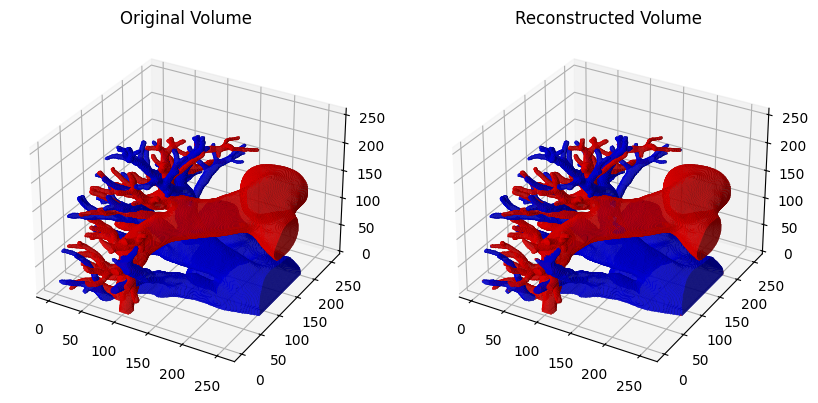

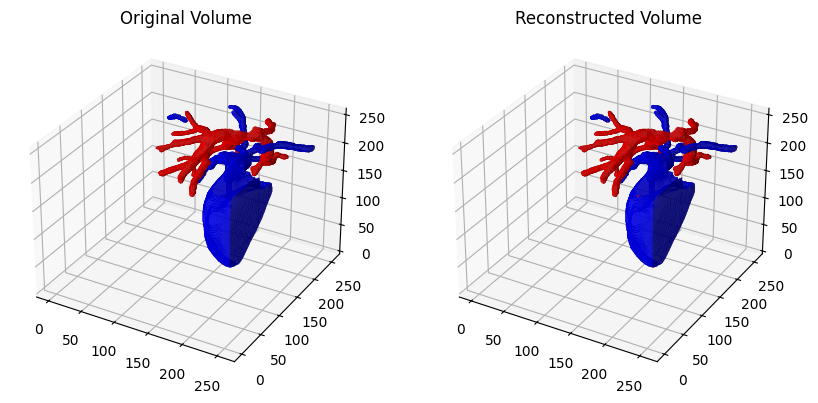

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

test_dir = "./images/3dTest"
test_data = MyDataset(test_dir, transform)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

model.eval()

# Define the color map
color_map = np.array([
    [0, 0, 0, 0],      # Transparent for background (0)
    [255, 0, 0, 255],  # Red for arteries (1)
    [0, 0, 255, 255]   # Blue for veins (2)
], dtype=np.uint8)

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(test_dataloader):
        x_hat = model(x)
        
        # Reconstruct and display the whole volume from the first test image
        original_volume = x[0, 0, :, :, :].detach().cpu().numpy().astype(int)  
        reconstruction_volume = np.argmax(x_hat[0,:,:,:,:], axis=0)

        # Plot original and reconstructed volumes with titles using Matplotlib
        fig = plt.figure(figsize=(10, 5))

        # Plot original volume with assigned colors and no edge color
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.set_title('Original Volume')

        # Define colors for each voxel value in the original volume using the color map
        original_colors = np.take(color_map, original_volume, axis=0) / 255.0
        ax1.voxels(original_volume, facecolors=original_colors)

        # Plot reconstructed volume with assigned colors and no edge color
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.set_title('Reconstructed Volume')

        # Define colors for each voxel value in the reconstructed volume using the color map
        reconstruction_colors = np.take(color_map, reconstruction_volume, axis=0) / 255.0
        ax2.voxels(reconstruction_volume, facecolors=reconstruction_colors)

        plt.show()
